## Maximum Likelihood Parameter Optimization

Now, we try maximum likelihood parameter optimization.  The basic idea is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have.

$P(a|x) \propto P(x|a)$

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

### Trial Problem

To observe how this works, we first do a trial problem. We generate data from a spring with a spring constant of `setconst`, and take the positive half.  We normalize such that the total number of particles is 100. This is our collected distribution.  We wish to recover the correct parameters for this distribution.  We treat it as a single parameter model with the force constant.  

Some initial math: if the force constant is $k$, then the unnormalized density is $e^{-kz^2/2RT} = e^{-x^2/2\sigma^2}$, so $\sigma^2 = RT/k$, and $\sigma = \sqrt{RT/k}$. The normalization constant for the Gaussian is $\sqrt{2\pi\sigma^2} = \sqrt{2\pi R T/k}$, which is $\sqrt{\pi R T/2k}$ for the half Gaussian.

In [17]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares,minimize

In [8]:
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant
T = 300  # units: K - temperature used for calculations

In [4]:
setconst=60 #spring constant
Np = 100 #normalized number of particles

In [9]:
zp = np.sqrt(R*T/setconst)*np.random.randn(100000) #normalization constant for gaussian * random data with gaussian dist
zph = zp[zp>0] #take only possitive side of gaussian

In [10]:
zp_ideal = lambda z: np.exp(-setconst*z*z/(2*R*T)) #unnormalized density
zp_norm = quad(zp_ideal,0,100)[0]
print(zp_norm)
zp_norm = np.sqrt(np.pi*R*T/(2*setconst)) #normalization constant for positive half of Gaussian
print(zp_norm)

8.080942810052731
8.080942810052731


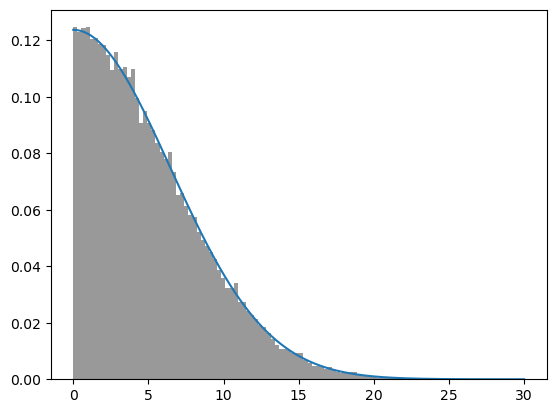

In [13]:
#Plotting half gaussian
zgrid = np.linspace(0,30,1000)
plt.plot(zgrid,zp_ideal(zgrid)/zp_norm)
plt.hist(zph,density=True,bins=100,color='k',alpha=0.4)
plt.show()

If $p_{ideal} = e^{-U/RT}$, then the concentration is $(N_p/p_{norm})\times p_{ideal}(z)$, and the probability of a particle occuring at a given distance is $p_{ideal}(z)/p_{norm}$.

We now assume that we don't know what distribution the data is taken from, but whsh to figure out the best fit of this distribution to a paramterized distribution.  We assume our parameterized concentration is of the form $f(a,z) = N e^{-az^2/2RT}$, multiplied by any needed normalizing constant $N$ to satisfy the total amount. The logarithm of this probability is $\ln p(a,z) = -\frac{az^2}{2RT} - \ln N$. We can figure out the normalizing constant of our parameterized distribution, but we do not know the true distribution, so we may have to estimate the normalizing constant. 


Next, we need to write out a formula for $\prod_i p(a,z_i)$.  Note that this needs to be the **normalized** probability, otherwise we won't be writing products of percentages.

We then attempt to maximize $\prod_i p(a,z_i)$, where the product is over the data samples we have collected.  The values of $a$ that maximize this product will be the maximum likelihood distribution. 

Generally it is more numerically stable, and often easier to work with, to maximize the log likelihood, $\ln \prod_i p(a,z_i) = \sum_i \ln p(a,z_i)$. 

For our trial function, the log likelihood is: 
$-az^2/(2RT)-\ln \sqrt{\pi R T/2a} = -az^2/(2RT) - 1/2 \ln (\pi R T/2) + 1/2\ln a$. If we want to minimize this, we can eliminate any terms that do not involve the parameter $a$, so we can minimize simply $-az^2/RT+ 1/2 \ln a$. 

In [14]:
def logp(a,z):
    return -a[0]*z*z/(2*R*T) + 0.5*np.log(a[0])

Set up the sum of the log probabilities of the data compared to the model.  Multiply it by -1 since we only have minimizers, not maximizers.

In [19]:
def nl(a,z):
    # sum of the log likelihood
    csum = np.sum(logp(a,z))
    return -1*csum

Now minimze!

In [20]:
results = minimize(nl,[4],args=(zph),method='L-BFGS-B')

The result is consistent with the model up to noise!

In [21]:
results.x

array([60.45573646])

In [22]:
results = minimize(nl,[100],args=(zph),method='L-BFGS-B')
print(results.x)

[60.45524005]


We get the right answer to within statistical precision.